In [7]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

In [8]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [9]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [10]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [31]:
PRE_TRAINED_ID = "/home/arunasrivastava/ML/notebooks/results-b10"

# Load Data

In [33]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [34]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))

In [35]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [36]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        # Add other necessary substitutions if needed
    }
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
train_df = files_to_df(training_files)
train_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihædjɹdɑɹksutnɡɹiziwɑʃwɔɾɹʔɔljiɹ,"[0, 2340, 4260, 5054, 6099, 8360, 9040, 9480, ...","[2340, 4260, 5054, 6099, 8360, 9040, 9480, 103..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðikaʊwʌndɹdfɹmðifɑɹmlɛninbikeɪmlɔst,"[0, 2026, 2548, 3379, 3990, 5060, 7227, 9148, ...","[2026, 2548, 3379, 3990, 5060, 7227, 9148, 997..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",lweɪɾiŋfɹttʃɪpɹʃikɹɪskɹɔstzəskwɛɹmɛnitaɪmz,"[0, 2200, 4052, 5213, 6440, 6880, 8062, 9560, ...","[2200, 4052, 5213, 6440, 6880, 8062, 9560, 113..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔeɪhjuddʒtæpistɹihʌŋiɾɹhɔlweɪ,"[0, 5640, 6182, 7080, 8438, 9107, 10440, 11210...","[5640, 6182, 7080, 8438, 9107, 10440, 11210, 1..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",əmɑnlɛtshɹidaʊnbəfɔɹðɛlɑkʌpfɔɹðideɪ,"[0, 2200, 3190, 3430, 4469, 6349, 7018, 7621, ...","[2200, 3190, 3430, 4469, 6349, 7018, 7621, 874..."


### Cleaning Up Audio

In [37]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

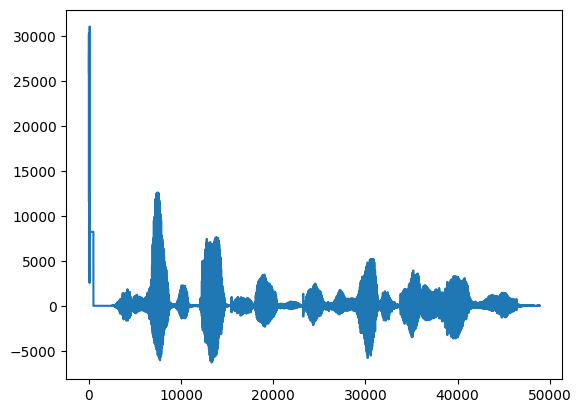

In [38]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [39]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1) 
train_df.head()
    

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃihædjɹdɑɹksutnɡɹiziwɑʃwɔɾɹʔɔljiɹ,"[0, 2340, 4260, 5054, 6099, 8360, 9040, 9480, ...","[2340, 4260, 5054, 6099, 8360, 9040, 9480, 103...","[-1, 0, 2, 2, 2, 1, 1, -2, -1, -3, 2, 1, 6, 7,..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðikaʊwʌndɹdfɹmðifɑɹmlɛninbikeɪmlɔst,"[0, 2026, 2548, 3379, 3990, 5060, 7227, 9148, ...","[2026, 2548, 3379, 3990, 5060, 7227, 9148, 997...","[0, -1, -1, 1, 0, -3, -1, 3, 1, 0, 0, -2, 0, 3..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",lweɪɾiŋfɹttʃɪpɹʃikɹɪskɹɔstzəskwɛɹmɛnitaɪmz,"[0, 2200, 4052, 5213, 6440, 6880, 8062, 9560, ...","[2200, 4052, 5213, 6440, 6880, 8062, 9560, 113...","[2, 2, 0, 6, 5, 6, 6, 8, 8, 8, 9, 8, 9, 8, 8, ..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔeɪhjuddʒtæpistɹihʌŋiɾɹhɔlweɪ,"[0, 5640, 6182, 7080, 8438, 9107, 10440, 11210...","[5640, 6182, 7080, 8438, 9107, 10440, 11210, 1...","[7, 9, 10, 6, 6, 6, 7, 1, 0, -1, -2, -8, -7, 0..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",əmɑnlɛtshɹidaʊnbəfɔɹðɛlɑkʌpfɔɹðideɪ,"[0, 2200, 3190, 3430, 4469, 6349, 7018, 7621, ...","[2200, 3190, 3430, 4469, 6349, 7018, 7621, 874...","[1, 4, 1, 5, 1, 4, 1, 2, 3, -1, 3, 4, 3, 6, 2,..."


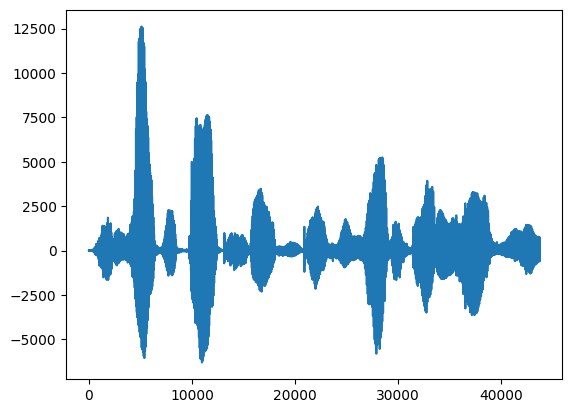

In [40]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [41]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

,ipa,audio
0,ʃihædjɹdɑɹksutnɡɹiziwɑʃwɔɾɹʔɔljiɹ,"[-1, 0, 2, 2, 2, 1, 1, -2, -1, -3, 2, 1, 6, 7,..."
1,ðikaʊwʌndɹdfɹmðifɑɹmlɛninbikeɪmlɔst,"[0, -1, -1, 1, 0, -3, -1, 3, 1, 0, 0, -2, 0, 3..."
2,lweɪɾiŋfɹttʃɪpɹʃikɹɪskɹɔstzəskwɛɹmɛnitaɪmz,"[2, 2, 0, 6, 5, 6, 6, 8, 8, 8, 9, 8, 9, 8, 8, ..."
3,ʔeɪhjuddʒtæpistɹihʌŋiɾɹhɔlweɪ,"[7, 9, 10, 6, 6, 6, 7, 1, 0, -1, -2, -8, -7, 0..."
4,əmɑnlɛtshɹidaʊnbəfɔɹðɛlɑkʌpfɔɹðideɪ,"[1, 4, 1, 5, 1, 4, 1, 2, 3, -1, 3, 4, 3, 6, 2,..."


In [42]:
train_ds = Dataset.from_pandas(train_df)

# Extend Phoneme Vocab

In [43]:
timit_vocab = set("".join(train_df['ipa']))

In [44]:
print(timit_vocab)

{'d', 'v', 'ɑ', 'i', 'n', 'j', 'θ', 'z', 'm', 'ʃ', 'ð', 'ʌ', 'ɡ', 't', 'ə', 'ŋ', 'ɔ', 'ɛ', 'ɪ', 'h', 'k', 'w', 'f', 'o', 's', 'p', 'ʔ', 'e', 'l', 'ʒ', 'æ', 'u', 'ʊ', 'ɹ', 'a', 'ɾ', 'b'}


In [45]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
print(vocab)

{'</s>': 2, '<pad>': 0, '<s>': 1, '<unk>': 3, 'a': 4, 'b': 5, 'd': 6, 'e': 7, 'f': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'z': 23, 'æ': 24, 'ð': 25, 'ŋ': 26, 'ɑ': 27, 'ɔ': 28, 'ə': 29, 'ɛ': 30, 'ɡ': 31, 'ɪ': 32, 'ɹ': 33, 'ɾ': 34, 'ʃ': 35, 'ʊ': 36, 'ʌ': 37, 'ʒ': 38, 'ʔ': 39, 'θ': 40}


In [46]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
tokenizer.add_tokens(list(additional_vocab))
print(additional_vocab)


set()


In [47]:
print(tokenizer.get_vocab())

{'</s>': 2, '<pad>': 0, '<s>': 1, '<unk>': 3, 'a': 4, 'b': 5, 'd': 6, 'e': 7, 'f': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'z': 23, 'æ': 24, 'ð': 25, 'ŋ': 26, 'ɑ': 27, 'ɔ': 28, 'ə': 29, 'ɛ': 30, 'ɡ': 31, 'ɪ': 32, 'ɹ': 33, 'ɾ': 34, 'ʃ': 35, 'ʊ': 36, 'ʌ': 37, 'ʒ': 38, 'ʔ': 39, 'θ': 40}


# Update Feature Extraction

In [48]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

### NEW FINE-TUNE CODE


In [ ]:
import torch
import tempfile
from transformers import AutoProcessor, AutoModelForCTC, Trainer, TrainingArguments, Wav2Vec2CTCTokenizer
from datasets import Dataset
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import logging
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.model_selection import train_test_split
import torchaudio
import json
from transformers.trainer_callback import EarlyStoppingCallback
#B1- LESS TRAINING EPOCHS
#B2- LENGTH PENALTY 
#B3- MORE TRAINING EPOCHS

NEW_MODEL_ID = "./notebooks/results-b10"

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Add max length check
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH  # Your existing constant
        )
        # Pad input_values
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            # Convert to tensor and ensure correct shape
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            # Remove any extra dimensions and ensure it's 1D
            input_values = input_values.squeeze()
            
            # Pad with zeros
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        # Stack all padded inputs ensuring correct dimensions [batch_size, sequence_length]
        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        # Process labels
        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch
def prepare_model_and_processor(timit_vocab):
    """
    Prepare the model and processor with reduced vocabulary and consistent special token IDs.
    """
    logger.info("Loading pretrained model and processor...")
    
    processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
    model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
    
    # Store the old vocabulary before making any changes
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    
    # Define fixed special token IDs - pad token first for CTC
    special_tokens = {
        "<pad>": 0,  # Changed to 0 for CTC blank token
        "<s>": 1,    # Shifted up
        "</s>": 2,   # Shifted up
        "<unk>": 3   # Shifted up
    }
    logger.info("Initial special tokens setup:")
    for token, idx in special_tokens.items():
        logger.info(f"{token}: {idx}")
    
    # Get regular tokens (excluding special tokens)
    regular_tokens = sorted(list(timit_vocab - set(special_tokens.keys())))
    
    # Create combined vocabulary with fixed IDs
    vocab = {**special_tokens}  # Start with special tokens
    
    # Add regular tokens after special tokens
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
    
    # Create tokenizer config with consistent token formats
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
    }
    
    # Save vocab to temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    # Create new tokenizer
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )
    
    # Verify tokenizer loaded correctly before proceeding
    loaded_vocab = new_tokenizer.get_vocab()
    logger.info("\nVerifying special token IDs in new tokenizer:")
    for token, expected_id in special_tokens.items():
        actual_id = loaded_vocab.get(token)
        logger.info(f"{token}: expected={expected_id}, actual={actual_id}")
        assert actual_id == expected_id, f"Token ID mismatch for {token}"
    
    # Update processor with new tokenizer
    processor.tokenizer = new_tokenizer
    os.remove(vocab_path)
    
    # Verify vocab size
    final_vocab_size = len(processor.tokenizer.get_vocab())
    logger.info(f"\nFinal vocabulary size: {final_vocab_size}")
    assert final_vocab_size == len(vocab), "Vocabulary size mismatch"
    
    # Handle model weights
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data
    
    # Create new layer
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    new_layer.weight.data.zero_()
    new_layer.bias.data.zero_()
    
    # Transfer weights and bias using the stored old_vocab
    for token, new_idx in loaded_vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
    
    model.lm_head = new_layer
    model.config.vocab_size = final_vocab_size
    model.config.pad_token_id = 0  # Explicitly set pad token as CTC blank token
    
    # Final verification
    logger.info("\nFinal vocabulary check:")
    final_vocab = processor.tokenizer.get_vocab()
    for token, expected_id in special_tokens.items():
        actual_id = final_vocab.get(token)
        logger.info(f"{token}: {actual_id}")
        assert actual_id == expected_id, f"Final token ID mismatch for {token}"
    
    return model, processor


def preprocess_audio(audio_input):
    """
    Load and preprocess audio to match expected format.
    
    Args:
        audio_input: Can be a file path (str), numpy array, list, or tensor
        
    Returns:
        np.ndarray: Processed audio as float32 numpy array
    """
    # Handle different input types
    if isinstance(audio_input, str):  # File path
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
        
    elif isinstance(audio_input, list):  # List input
        audio_numpy = np.array(audio_input, dtype=np.float32)
        
    elif isinstance(audio_input, np.ndarray):  # Already numpy array
        audio_numpy = audio_input
        
    elif isinstance(audio_input, torch.Tensor):  # Torch tensor
        audio_numpy = audio_input.numpy()
        
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    # Ensure float32 dtype
    audio_numpy = audio_numpy.astype(np.float32)
    
    # Ensure 1D array
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    # Normalize audio
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    # Trim or pad to max length
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy

def prepare_datasets(train_df, processor):
    """
    Dataset preparation compatible with original data collator
    """
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        # Preprocess audio
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()
        
        # Process audio without any padding or tensor conversion
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        # Process labels without any padding or tensor conversion
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    # Convert DataFrames to Datasets with optimized batch processing
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    # Apply processing with larger batches
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )
    
    return train_dataset, eval_dataset

def prepare_datasets(train_df, processor):
    """
    Dataset preparation compatible with original data collator
    """
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        # Preprocess audio
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()
        
        # Process audio without any padding or tensor conversion
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        # Process labels without any padding or tensor conversion
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    # Convert DataFrames to Datasets with optimized batch processing
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    # Apply processing with larger batches
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )
    
    return train_dataset, eval_dataset

def verify_dimensions(batch, logger):
    """
    Debug helper to verify tensor dimensions
    """
    logger.info("Batch dimensions:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            logger.info(f"{key}: {value.shape}")


def verify_token_ids(processor, stage=""):
    """
    Simple token verification function
    """
    logger.info(f"\n=== Token ID Verification [{stage}] ===")
    vocab = processor.tokenizer.get_vocab()
    logger.info(f"Vocabulary size: {len(vocab)}")
    
    # Check special tokens
    special_tokens = ["<pad>", "<s>", "</s>", "<unk>"]
    for token in special_tokens:
        token_id = vocab.get(token)
        logger.info(f"Token {token}: ID {token_id}")
    
    # Sample a few regular tokens
    regular_tokens = [t for t in list(vocab.keys())[:5] if t not in special_tokens]
    logger.info("Sample regular token IDs:")
    for token in regular_tokens:
        logger.info(f"Token {token}: ID {vocab[token]}")
    
    return vocab

def main(train_df, timit_vocab):
    """
    Modified main training pipeline with optimized parameters based on hyperparameter search
    """
    wandb.init(project="xlsr-buckeye-phoneme-prediction-overnight")
    
    model, processor = prepare_model_and_processor(timit_vocab)
    
    vocab = verify_token_ids(processor, "After Model Preparation")
    logger.info(f"Full vocabulary: {vocab}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()
    
    # Prepare datasets with optimized batch processing
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    
    # Modified training arguments based on hyperparameter search results
    training_args = TrainingArguments(
        output_dir="./results-b10",
        # Trial 4's best performing parameters
        learning_rate=1e-6,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=4,
        max_grad_norm=0.907,
        
        # Optimizer parameters from best trial
        adam_beta1=0.93287,
        adam_beta2=0.96748,
        adam_epsilon=1e-8,
        weight_decay=0.00599,
        
        # Learning rate schedule
        warmup_ratio=0.08253,
        lr_scheduler_type="linear",
        
        # Training duration and evaluation
        num_train_epochs=50,
        logging_dir='./logs',
        logging_steps=10,
        save_steps=300,
        eval_steps=50,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        
        # Model saving strategy
        save_safetensors=True,
        save_strategy="steps",
        save_total_limit=3,
        
        # Performance optimizations
        fp16=True,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=True,
    )
    
    # Modified data collator with efficient padding
    data_collator = DataCollatorCTCWithPadding(
        processor=processor,
        padding="longest"
    )
    
    # Add early stopping callback
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=5,
        early_stopping_threshold=0.01
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        callbacks=[early_stopping]
    )
    
    # Train model with optimized parameters
    trainer.train("/home/arunasrivastava/ML/notebooks/results-b10/checkpoint-2700")
    
    # Save the final model and processor
    model.save_pretrained("./results-b10")
    processor.save_pretrained("./results-b10")
    
    # Verify tokens after training
    verify_token_ids(processor, "After Training")
    
    # Final inference verification
    logger.info("Running inference on sample...")
    sample_audio = train_dataset[0]["audio"]
    inputs = processor(sample_audio, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    
    predicted_tokens = processor.batch_decode(predicted_ids)
    cleaned_prediction = (predicted_tokens[0]
                        .replace('<s>', '')
                        .replace('</s>', '')
                        .replace('<pad>', '')
                        .replace('<unk>', '')
                        .strip())
    
    logger.info(f"Sample raw prediction: {predicted_tokens}")
    logger.info(f"Sample cleaned prediction: {cleaned_prediction}")
    
    wandb.finish()

if __name__ == "__main__":
    main(train_df, timit_vocab)

## Hyperparam search


In [49]:
%pip install optuna joblib

Note: you may need to restart the kernel to use updated packages.


In [52]:
import torch
import tempfile
from transformers import AutoProcessor, AutoModelForCTC, Trainer, TrainingArguments, Wav2Vec2CTCTokenizer
from datasets import Dataset
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import logging
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.model_selection import train_test_split
import torchaudio
import json
from transformers.trainer_callback import EarlyStoppingCallback

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Add max length check
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH  # Your existing constant
        )
        # Pad input_values
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            # Convert to tensor and ensure correct shape
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            # Remove any extra dimensions and ensure it's 1D
            input_values = input_values.squeeze()
            
            # Pad with zeros
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        # Stack all padded inputs ensuring correct dimensions [batch_size, sequence_length]
        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        # Process labels
        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch
def prepare_model_and_processor(timit_vocab):
    """
    Prepare the model and processor with reduced vocabulary and consistent special token IDs.
    """
    logger.info("Loading pretrained model and processor...")
    
    processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
    model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
    
    # Store the old vocabulary before making any changes
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    
    # Define fixed special token IDs - pad token first for CTC
    special_tokens = {
        "<pad>": 0,  # Changed to 0 for CTC blank token
        "<s>": 1,    # Shifted up
        "</s>": 2,   # Shifted up
        "<unk>": 3   # Shifted up
    }
    logger.info("Initial special tokens setup:")
    for token, idx in special_tokens.items():
        logger.info(f"{token}: {idx}")
    
    # Get regular tokens (excluding special tokens)
    regular_tokens = sorted(list(timit_vocab - set(special_tokens.keys())))
    
    # Create combined vocabulary with fixed IDs
    vocab = {**special_tokens}  # Start with special tokens
    
    # Add regular tokens after special tokens
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
    
    # Create tokenizer config with consistent token formats
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "<pad>",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "<unk>",
    }
    
    # Save vocab to temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    # Create new tokenizer
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )
    
    # Verify tokenizer loaded correctly before proceeding
    loaded_vocab = new_tokenizer.get_vocab()
    logger.info("\nVerifying special token IDs in new tokenizer:")
    for token, expected_id in special_tokens.items():
        actual_id = loaded_vocab.get(token)
        logger.info(f"{token}: expected={expected_id}, actual={actual_id}")
        assert actual_id == expected_id, f"Token ID mismatch for {token}"
    
    # Update processor with new tokenizer
    processor.tokenizer = new_tokenizer
    os.remove(vocab_path)
    
    # Verify vocab size
    final_vocab_size = len(processor.tokenizer.get_vocab())
    logger.info(f"\nFinal vocabulary size: {final_vocab_size}")
    assert final_vocab_size == len(vocab), "Vocabulary size mismatch"
    
    # Handle model weights
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data
    
    # Create new layer
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    new_layer.weight.data.zero_()
    new_layer.bias.data.zero_()
    
    # Transfer weights and bias using the stored old_vocab
    for token, new_idx in loaded_vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
    
    model.lm_head = new_layer
    model.config.vocab_size = final_vocab_size
    model.config.pad_token_id = 0  # Explicitly set pad token as CTC blank token
    
    # Final verification
    logger.info("\nFinal vocabulary check:")
    final_vocab = processor.tokenizer.get_vocab()
    for token, expected_id in special_tokens.items():
        actual_id = final_vocab.get(token)
        logger.info(f"{token}: {actual_id}")
        assert actual_id == expected_id, f"Final token ID mismatch for {token}"
    
    return model, processor

In [50]:
import optuna
from transformers import TrainingArguments, EarlyStoppingCallback, Trainer
from functools import partial
import wandb
from transformers import AutoModelForCTC, AutoProcessor


def objective(trial, train_df, timit_vocab, base_output_dir="./results"):
    """
    Optuna objective function for hyperparameter optimization
    """
    # Generate a unique run name
    run_name = f"b10_trial_{trial.number}"
    output_dir = f"{base_output_dir}/{run_name}"
    
    # Initialize wandb for this trial
    wandb.init(
        project="xlsr-buckeye-phoneme-prediction",
        name=run_name,
        config={"trial_number": trial.number, "base_model": "/home/arunasrivastava/ML/notebooks/results-b10"},
        reinit=True
    )
    
    # Sample hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16])
    grad_accum = trial.suggest_categorical("gradient_accumulation_steps", [2, 4, 8])
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.15)
    weight_decay = trial.suggest_float("weight_decay", 0.001, 0.05, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_beta1 = trial.suggest_float("adam_beta1", 0.85, 0.95)
    adam_beta2 = trial.suggest_float("adam_beta2", 0.95, 0.999)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-9, 1e-7, log=True)
    
    # Prepare model and data - now using model-b10
    model, processor = prepare_model_and_processor(timit_vocab)
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    
    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()
    
    # Create training arguments with sampled hyperparameters
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=grad_accum,
        max_grad_norm=max_grad_norm,
        warmup_ratio=warmup_ratio,
        lr_scheduler_type="cosine",
        weight_decay=weight_decay,
        num_train_epochs=5,  # Reduced epochs for faster search
        logging_dir=f'{output_dir}/logs',
        logging_steps=50,
        save_steps=500,
        eval_steps=100,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_safetensors=True,
        save_strategy="steps",
        save_total_limit=1,  # Keep only best model
        fp16=True,
        fp16_full_eval=True,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
        gradient_checkpointing=True,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,
    )
    
    # Create early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.01
    )
    
    # Create trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorCTCWithPadding(processor=processor, padding="longest"),
        callbacks=[early_stopping_callback]  # Add early stopping callback
    )
    
    # Train and get best eval loss
    try:
        train_result = trainer.train()
        eval_result = trainer.evaluate()
        
        # Report to wandb
        wandb.log({
            "best_eval_loss": eval_result["eval_loss"],
            "final_train_loss": train_result.training_loss,
            **{f"hp_{k}": v for k, v in trial.params.items()}
        })
        
        wandb.finish()
        
        return eval_result["eval_loss"]
    
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {str(e)}")
        wandb.finish()
        return float('inf')

def run_hyperparameter_search(train_df, timit_vocab, n_trials=20):
    """
    Run the hyperparameter search
    """
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=1
        )
    )
    
    study.optimize(
        partial(objective, train_df=train_df, timit_vocab=timit_vocab),
        n_trials=n_trials,
        timeout=3600 * 12  # 12 hour timeout
    )
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study

if __name__ == "__main__":
    study = run_hyperparameter_search(train_df, timit_vocab)
    
    # Save study results
    import joblib
    joblib.dump(study, "hyperparam_study.pkl")

[I 2024-12-01 23:41:13,772] A new study created in memory with name: no-name-863eed74-79d5-48af-9b70-a0f60f1773f6


INFO:__main__:Loading pretrained model and processor...
INFO:__main__:Initial vocabulary size: 41
INFO:__main__:Initial special tokens setup:
INFO:__main__:<pad>: 0
INFO:__main__:<s>: 1
INFO:__main__:</s>: 2
INFO:__main__:<unk>: 3
INFO:__main__:
Verifying special token IDs in new tokenizer:
INFO:__main__:<pad>: expected=0, actual=0
INFO:__main__:<s>: expected=1, actual=1
INFO:__main__:</s>: expected=2, actual=2
INFO:__main__:<unk>: expected=3, actual=3
INFO:__main__:
Final vocabulary size: 41
INFO:__main__:
Final vocabulary check:
INFO:__main__:<pad>: 0
INFO:__main__:<s>: 1
INFO:__main__:</s>: 2
INFO:__main__:<unk>: 3
INFO:__main__:Splitting dataset into train and evaluation...
Map (num_proc=4):   0%|          | 0/3696 [00:00<?, ? examples/s]/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the 

Step,Training Loss,Validation Loss
100,2.472000,1.080993
200,2.370000,1.082280


/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasrivastava/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labe

In [2]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
from huggingface_hub import login

# Log in to Hugging Face (if not already logged in)
login("your-huggingface-api-token")

# Load the model and processor from your local directory
model = AutoModelForCTC.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b10")
processor = Wav2Vec2Processor.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b10")

# Specify the directory where you want to save the model
save_directory = "./xlsr-timit-a0"

# Save and upload to Hugging Face Model Hub under an organization
model.save_pretrained(save_directory, push_to_hub=True, repo_id="KoelLabs/xlsr-timit-a0")
processor.save_pretrained(save_directory)

# Upload other files in the directory to Hugging Face Model Hub


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/arunasrivastava/.cache/huggingface/token
Login successful


model.safetensors: 100%|██████████| 1.26G/1.26G [00:29<00:00, 42.9MB/s]


[]